# Population Stratification 

This is the presence of multiple subpopulations (e.g., individuals with different ethnic background) in a study. Because allele frequencies can differ between subpopulations, population stratification can lead to false positive associations and/or mask true associations. 

To complete this task it is necessary to have generated the bfile 'dataset.b37_IBD' and the file 'indepSNP.prune.in' from the previous tutorial (Task_2_QC). This bfile is going to checked for population stratification using data from the 1000 Genomes Project. Individuals with a non-European ethnic background will be removed. 1000 Genomes data need to undergo QC before hand; this is ready here but you / the user can also do it following the template Task_2.2.1_PopulationStratification_Prepare1000GenomeDataset.

Furthermore, this guide will generate a covariate file which helps to adust for remaining population stratification within the European subjects.

This protocol follows the tutorial explained in Marees AT, de Kluiver H, Stringer S, et al. A tutorial on conducting genome-wide association studies: Quality control and statistical analysis. Int J Methods Psychiatr Res. 2018;27(2):e1608.doi:10.1002/mpr.1608

In [1]:
%load_ext rpy2.ipython

In [2]:
%env path= /mnt/data/GWAS/output/task2.2_stratification
%env intpath=/mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets

env: path=/mnt/data/GWAS/output/task2.2_stratification
env: intpath=/mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets


In [168]:
%%R
# Import functions for visualisation
source("scripts/QC_functions_task2.R")

## Merge the working dataset (a.k.a. HapMap) and 1000 Genomes data sets 

Prior to merging 1000 Genomes data with the HapMap data we want to make sure that the files are mergeable, for this we conduct 5 steps:
1. Extract the variants present in one dataset from the other
2. Make sure the datasets have the same build
3. Make sure the reference genome is similar in the working dataset and the 1000 Genomes Project datasets.
4. Resolve strand issues.
5. Remove the SNPs which after the previous two steps still differ between datasets.

### Extract the variants present in one dataset from the other

In [110]:
%%bash
# Extract the variants present in the working dataset from the 1000 genomes dataset.
awk '{print$2}' $path/../task2_QC/intermediate_datasets/dataset.b37.IBD.bim > $path/dataset.b37_SNPs.txt
plink --bfile $intpath/1kG_MDS3 --extract $path/dataset.b37_SNPs.txt --make-bed --out $intpath/1kG_MDS4

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS4.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS3
  --extract /mnt/data/GWAS/output/task2.2_stratification/dataset.b37_SNPs.txt
  --make-bed
  --out /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS4

32127 MB RAM detected; reserving 16063 MB for main workspace.
6047414 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS4.nosex
.
--extract: 6047414 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2504 founders and 0 nonfounders present.
Calculating allele fre

In [111]:
%%bash
head $path/dataset.b37_SNPs.txt

1:10177
1:11008
1:11012
1:13110
rs201725126
rs200579949
1:13273
1:14464
1:14599
1:14604


In [112]:
%%bash
# Extract the variants present in 1000 Genomes dataset from the working dataset.
awk '{print$2}' $intpath/1kG_MDS4.bim > $path/1kG_MDS_SNPs.txt
plink --bfile $path/../task2_QC/intermediate_datasets/dataset.b37.IBD --extract $path/1kG_MDS_SNPs.txt --recode --make-bed --out $intpath/dataset.b37_MDS
# The datasets now contain the exact same variants.


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_MDS.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/task2_QC/intermediate_datasets/dataset.b37.IBD
  --extract /mnt/data/GWAS/output/task2.2_stratification/1kG_MDS_SNPs.txt
  --make-bed
  --out /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_MDS
  --recode

32127 MB RAM detected; reserving 16063 MB for main workspace.
7076087 variants loaded from .bim file.
496 people (237 males, 259 females) loaded from .fam.
496 phenotype values loaded from .fam.
--extract: 6047414 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 496 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940

### Build

The datasets must have the same build. Change the build 1000 Genomes data build.

In [114]:
%%bash
awk '{print$2,$4}' $intpath/dataset.b37_MDS.map > $path/buildhapmap.txt
# buildhapmap.txt contains one SNP-id and physical position per line.
head $path/buildhapmap.txt

rs200579949 13118
rs141149254 54490
rs114420996 58814
rs201888535 63735
rs115209712 86331
rs940550 88169
rs55700207 88338
rs377161483 129010
rs371474651 158006
rs144169752 232449


In [115]:
%%bash
plink --bfile $intpath/1kG_MDS4 --update-map $path/buildhapmap.txt --make-bed --out $intpath/1kG_MDS5
# 1kG_MDS5 and the dataset under study now have the same build.

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS5.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS4
  --make-bed
  --out /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS5
  --update-map /mnt/data/GWAS/output/task2.2_stratification/buildhapmap.txt

32127 MB RAM detected; reserving 16063 MB for main workspace.
6047414 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS5.nosex
.
--update-map: 6047414 values updated.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2504 founders and 0 nonfounders present.
Calculating allele freque

### set reference genome

In [116]:
%%bash
awk '{print$2,$5}' $intpath/1kG_MDS5.bim > $path/1kg_ref-list.txt
plink --bfile $intpath/dataset.b37_MDS --reference-allele $path/1kg_ref-list.txt --make-bed --out $intpath/dataset.b37_adj
# The 1kG_MDS7 and the dataset.b37_adj have the same reference genome for all SNPs.
# This command will generate some warnings for impossible A1 allele assignment.


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_adj.log.
Options in effect:
  --a1-allele /mnt/data/GWAS/output/task2.2_stratification/1kg_ref-list.txt
  --bfile /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_MDS
  --make-bed
  --out /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_adj

32127 MB RAM detected; reserving 16063 MB for main workspace.
6047414 variants loaded from .bim file.
496 people (237 males, 259 females) loaded from .fam.
496 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 496 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657

In [117]:
%%bash
head $path/1kg_ref-list.txt

rs200579949 G
rs141149254 A
rs114420996 A
rs201888535 C
rs115209712 G
rs940550 T
rs55700207 A
rs377161483 A
rs371474651 T
rs144169752 A


### Resolve strand issues

In [123]:
%%bash
# Check for potential strand issues.
awk '{print$2,$5,$6}' $intpath/1kG_MDS5.bim > $intpath/1kGMDS5_tmp
awk '{print$2,$5,$6}' $intpath/dataset.b37_adj.bim > $intpath/dataset.b37_adj_tmp
sort $intpath/1kGMDS5_tmp $intpath/dataset.b37_adj_tmp |uniq -u > $path/all_differences.txt
# 1624 differences between the files, some of these might be due to strand issues.
head $path/all_differences.txt

rs10013793 G T
rs10013793 T TTG
rs10544831 A ATT
rs10544831 C T
rs10546076 C T
rs10546076 T TGTTC
rs10566332 C CAT
rs10566332 C T
rs10569851 A AAC
rs10569851 A C


In [124]:
%%bash
# Flip SNPs for resolving strand issues.
# Print SNP-identifier and remove duplicates.
awk '{print$1}' $path/all_differences.txt | sort -u > $path/flip_list.txt
# Generates a file of 329 SNPs. These are the non-corresponding SNPs between the two files. 
# Flip the 329 non-corresponding SNPs. 
plink --bfile $intpath/dataset.b37_adj --flip $path/flip_list.txt --reference-allele $path/1kg_ref-list.txt --make-bed --out $intpath/dataset.b37.corrected
# This command will generate some warnings for impossible A1 allele assignment.

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37.corrected.log.
Options in effect:
  --a1-allele /mnt/data/GWAS/output/task2.2_stratification/1kg_ref-list.txt
  --bfile /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_adj
  --flip /mnt/data/GWAS/output/task2.2_stratification/flip_list.txt
  --make-bed
  --out /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37.corrected

32127 MB RAM detected; reserving 16063 MB for main workspace.
6047414 variants loaded from .bim file.
496 people (237 males, 259 females) loaded from .fam.
496 phenotype values loaded from .fam.
--flip: 329 SNPs flipped.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 496 founders and 0 nonfounders present.
Calculating allele frequ

In [120]:
%%bash
# Check for SNPs which are still problematic after they have been flipped.
awk '{print$2,$5,$6}' $intpath/dataset.b37.corrected.bim > $intpath/dataset.b37.corrected_tmp
sort $intpath/1kGMDS6_tmp $intpath/dataset.b37.corrected_tmp |uniq -u  > $path/uncorresponding_SNPs.txt

In [121]:
%%bash
# This file demonstrates that there are 652 differences between the files.
wc -l $path/uncorresponding_SNPs.txt
head $path/uncorresponding_SNPs.txt

652 /mnt/data/GWAS/output/task2.2_stratification/uncorresponding_SNPs.txt
rs10013793 A TTG
rs10013793 G T
rs10544831 C T
rs10544831 T ATT
rs10546076 A TGTTC
rs10546076 C T
rs10566332 A G
rs10566332 C CAT
rs10569851 A C
rs10569851 T AAC


### Remove problematic SNPs from the dataset under study and 1000 Genomes

In [122]:
%%bash
awk '{print$1}' $path/uncorresponding_SNPs.txt | sort -u > $path/SNPs_for_exlusion.txt
# The command above generates a list of the SNPs which caused the 652 differences between the working dataset (i.e HapMap) and the 1000 Genomes data sets after flipping and setting of the reference genome.
head $path/SNPs_for_exlusion.txt

rs10013793
rs10544831
rs10546076
rs10566332
rs10569851
rs10598951
rs10627420
rs10650743
rs10654837
rs10663307


In [125]:
%%bash
# Remove the problematic SNPs from both datasets.
plink --bfile $intpath/dataset.b37.corrected --exclude $path/SNPs_for_exlusion.txt --make-bed --out $intpath/dataset.b37_MDS2
plink --bfile $intpath/1kG_MDS5 --exclude $path/SNPs_for_exlusion.txt --make-bed --out $intpath/1kG_MDS6


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_MDS2.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37.corrected
  --exclude /mnt/data/GWAS/output/task2.2_stratification/SNPs_for_exlusion.txt
  --make-bed
  --out /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_MDS2

32127 MB RAM detected; reserving 16063 MB for main workspace.
6047414 variants loaded from .bim file.
496 people (237 males, 259 females) loaded from .fam.
496 phenotype values loaded from .fam.
--exclude: 6047088 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 496 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132

### Merge the dataset under study (HapMap) with 1000 Genomes Data

In [126]:
%%bash
# Merge HapMap with 1000 Genomes Data.
plink --bfile $intpath/dataset.b37_MDS2 --bmerge $intpath/1kG_MDS6.bed $intpath/1kG_MDS6.bim $intpath/1kG_MDS6.fam --allow-no-sex --make-bed --out $path/MDS_merge2

# Note, we are fully aware of the sample overlap between the HapMap and 1000 Genomes datasets. However, for the purpose of this tutorial this is not important.


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/MDS_merge2.log.
Options in effect:
  --allow-no-sex
  --bfile /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_MDS2
  --bmerge /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS6.bed /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS6.bim /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS6.fam
  --make-bed
  --out /mnt/data/GWAS/output/task2.2_stratification/MDS_merge2

32127 MB RAM detected; reserving 16063 MB for main workspace.
496 people loaded from
/mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37_MDS2.fam.
2504 people to be merged from
/mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/1kG_MDS6.fam.
Of these, 2504 are new, wh

## Perform Multidimensional Scaling (MDS) on HapMap-CEU data anchored by 1000 Genomes data

In [127]:
%%bash
# Using a set of pruned SNPs
plink --bfile $path/MDS_merge2 --extract $path/../task2_QC/indepSNP.prune.in --genome --out $path/MDS_merge2
plink --bfile $path/MDS_merge2 --read-genome $path/MDS_merge2.genome --cluster --mds-plot 10 --out $path/MDS_merge2


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/MDS_merge2.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/task2.2_stratification/MDS_merge2
  --extract /mnt/data/GWAS/output/task2.2_stratification/../task2_QC/indepSNP.prune.in
  --genome
  --out /mnt/data/GWAS/output/task2.2_stratification/MDS_merge2

32127 MB RAM detected; reserving 16063 MB for main workspace.
6047088 variants loaded from .bim file.
3000 people (237 males, 259 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/mnt/data/GWAS/output/task2.2_stratification/MDS_merge2.nosex .
496 phenotype values loaded from .fam.
--extract: 307793 variants remaining.
Using up to 8 threads (change this with --threads).
Before main variant filters, 3000 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202

## MDS-plot

In [130]:
%%bash
# 1000 Genomes superpopulation codes
wc -l /mnt/data/GWAS/ref_files/1000G_superpopulation_codes.txt
head /mnt/data/GWAS/ref_files/1000G_superpopulation_codes.txt

2505 /mnt/data/GWAS/ref_files/1000G_superpopulation_codes.txt
FID	IID	SuperPop
HG00096	HG00096	EUR
HG00097	HG00097	EUR
HG00099	HG00099	EUR
HG00100	HG00100	EUR
HG00101	HG00101	EUR
HG00102	HG00102	EUR
HG00103	HG00103	EUR
HG00105	HG00105	EUR
HG00106	HG00106	EUR


In [131]:
%%bash
# Create a racefile of your own data.
awk '{print$1,$2,"OWN"}' $intpath/dataset.b37_MDS.fam>$path/racefile_own.txt
head $path/racefile_own.txt

HGX00096 HGX00096 OWN
HGX00097 HGX00097 OWN
HGX00099 HGX00099 OWN
HGX00100 HGX00100 OWN
HGX00101 HGX00101 OWN
HGX00102 HGX00102 OWN
HGX00103 HGX00103 OWN
HGX00105 HGX00105 OWN
HGX00106 HGX00106 OWN
HGX00107 HGX00107 OWN


In [154]:
%%bash
# Concatenate racefiles.
cat /mnt/data/GWAS/ref_files/1000G_superpopulation_codes.txt $path/racefile_own.txt  > $path/racefile.txt
head $path/racefile.txt


FID	IID	SuperPop
HG00096	HG00096	EUR
HG00097	HG00097	EUR
HG00099	HG00099	EUR
HG00100	HG00100	EUR
HG00101	HG00101	EUR
HG00102	HG00102	EUR
HG00103	HG00103	EUR
HG00105	HG00105	EUR
HG00106	HG00106	EUR


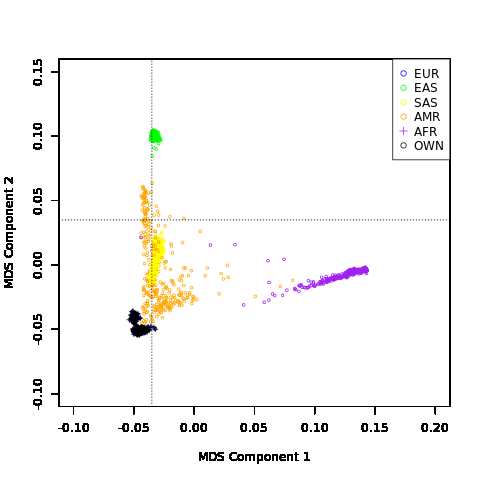

In [187]:
%%R
MDS_function("/mnt/data/GWAS/output/task2.2_stratification/MDS_merge2.mds","/mnt/data/GWAS/output/task2.2_stratification/racefile.txt")


**The plot shows that our "own" data falls within the European group of the 1000 genomes data. Therefore, we do not have to remove subjects.**

Anyway we are running the filtering step for educational purposes.

In [159]:
%%bash
# to make zoom - but the plot axis are fixed / hard coded so it is not possible with the current code
grep "EUR\|OWN" $path/racefile.txt | sed -e '1i\FID IID race' > $path/EURracefile.txt
wc -l $path/EURracefile.txt

1000 /mnt/data/GWAS/output/task2.2_stratification/EURracefile.txt


### Filter out population stratification outliers

#### Exclude ethnic outliers

In [161]:
%%bash
head $path/MDS_merge2.mds

      FID       IID    SOL           C1           C2           C3           C4           C5           C6           C7           C8           C9          C10 
  HG00096   HG00096      0   -0.0477257   -0.0508167    0.0102372    0.0109444  -0.00121588 -0.000614106   0.00489702   -0.0118193   0.00952079   -0.0102924 
  HG00097   HG00097      0   -0.0481964   -0.0508435   0.00967419   0.00906823  -0.00110833  -0.00162257  -0.00463493   -0.0135497    0.0162267   -0.0107302 
  HG00099   HG00099      0   -0.0500857   -0.0512144   0.00970879   0.00773405  -0.00362059  -0.00205046    0.0233334  -0.00833883   0.00876377   -0.0121939 
  HG00100   HG00100      0   -0.0452664   -0.0512332   0.00938461    0.0102627   0.00122994 -2.58053e-05    0.0148318    -0.018067   0.00318354    0.0036782 
  HG00101   HG00101      0   -0.0468008   -0.0505854   0.00986659   0.00841507  -0.00295276  -0.00155352    0.0226476   -0.0149448   0.00676548  -0.00827814 
  HG00102   HG00102      0   -0.0493259   -0.0505265

In [210]:
%%bash
# Select individuals in the working data below cut-off thresholds. The cut-off levels are not fixed thresholds but have to be determined based on the visualization of the first two dimensions. 
# To exclude ethnic outliers, the thresholds need to be set around the cluster of population of interest.
awk '{ if ($4 <-0.02 && $5 < -0.02)  print $1,$2 }' $path/MDS_merge2.mds > $path/EUR_MDS_merge2
wc -l $path/MDS_merge2.mds
wc -l $path/EUR_MDS_merge2

3001 /mnt/data/GWAS/output/task2.2_stratification/MDS_merge2.mds
1100 /mnt/data/GWAS/output/task2.2_stratification/EUR_MDS_merge2


In [214]:
%%bash
# Extract these individuals in the working dataset.
plink --bfile $path/../task2_QC/intermediate_datasets/dataset.b37.IBD --keep $path/EUR_MDS_merge2 --make-bed --out $intpath/dataset.b37.outliers


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37.outliers.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/task2.2_stratification/../task2_QC/intermediate_datasets/dataset.b37.IBD
  --keep /mnt/data/GWAS/output/task2.2_stratification/EUR_MDS_merge2
  --make-bed
  --out /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37.outliers

32127 MB RAM detected; reserving 16063 MB for main workspace.
7076087 variants loaded from .bim file.
496 people (237 males, 259 females) loaded from .fam.
496 phenotype values loaded from .fam.
--keep: 496 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 496 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343

/mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37.outliers.hh
); many commands treat these as missing.


#### Create covariates based on MDS

In [215]:
%%bash
# Perform an MDS ONLY on HapMap data without ethnic outliers. The values of the 10 MDS dimensions are subsequently used as covariates in the association analysis in the third tutorial.
plink --bfile $intpath/dataset.b37.outliers --extract $path/../task2_QC/indepSNP.prune.in --genome --out $path/dataset.b37.outliers
plink --bfile $intpath/dataset.b37.outliers --read-genome $path/dataset.b37.outliers.genome --cluster --mds-plot 10 --out $path/dataset.b37.mds


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/task2.2_stratification/dataset.b37.outliers.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37.outliers
  --extract /mnt/data/GWAS/output/task2.2_stratification/../task2_QC/indepSNP.prune.in
  --genome
  --out /mnt/data/GWAS/output/task2.2_stratification/dataset.b37.outliers

32127 MB RAM detected; reserving 16063 MB for main workspace.
7076087 variants loaded from .bim file.
496 people (237 males, 259 females) loaded from .fam.
496 phenotype values loaded from .fam.
--extract: 473808 variants remaining.
Using up to 8 threads (change this with --threads).
Before main variant filters, 496 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950

/mnt/data/GWAS/output/task2.2_stratification/dataset.b37.outliers.hh ); many
commands treat these as missing.
/mnt/data/GWAS/output/task2.2_stratification/dataset.b37.mds.hh ); many
commands treat these as missing.


In [217]:
%%bash
paste awk '{print$5, $6,}' /mnt/data/GWAS/output/task2.2_stratification/intermediate_datasets/dataset.b37.outliers.fam $path/covar_mds.txt > $path/covar_mds_age_pheno.txt
head $path/covar_mds_age_pheno.txt

HGX00096 HGX00096 0 0 1 1
HGX00097 HGX00097 0 0 2 1
HGX00099 HGX00099 0 0 2 1
HGX00100 HGX00100 0 0 2 1
HGX00101 HGX00101 0 0 1 1
HGX00102 HGX00102 0 0 2 1
HGX00103 HGX00103 0 0 1 1
HGX00105 HGX00105 0 0 1 1
HGX00106 HGX00106 0 0 2 1
HGX00107 HGX00107 0 0 1 1


In [ ]:
%%bash
cp $path/covar_mds.txt $path/covar_mds_age_pheno.txt
paste -d' ' $path/covar_mds_age_pheno.txt <(cut -d' ' -f2 file2)

In [213]:
%%bash
# Change the format of the .mds file into a plink covariate file.
awk '{print$1, $2, $4, $5, $6, $7, $8, $9, $10, $11, $12, $13}' $path/dataset.b37.mds.mds > $path/covar_mds.txt
head $path/covar_mds.txt
# The values in covar_mds.txt will be used as covariates, to adjust for remaining population stratification, in the next pipeline/protocol/task where we will perform a genome-wide association analysis.

FID IID C1 C2 C3 C4 C5 C6 C7 C8 C9 C10
HGX00096 HGX00096 -0.000130168 0.0148262 -0.00246446 -0.00800308 0.00270028 -0.00956846 0.00552736 0.0035352 -0.0125891 0.0173253
HGX00097 HGX00097 -0.000255721 0.0139714 -0.00270998 -0.0107841 0.0176906 -0.00404297 -0.000167033 -0.0165653 -0.00459382 0.0126304
HGX00099 HGX00099 0.00133495 0.0184345 -0.00508777 -0.0169761 -0.0099984 -0.00443926 0.00353687 0.00513696 -0.00120698 0.0253017
HGX00100 HGX00100 -0.00332729 0.0183462 0.0179926 -0.00526761 -0.00754295 -0.00621013 -0.000163235 -0.00216034 -0.029367 0.026805
HGX00101 HGX00101 0.000702511 0.0211981 -0.00266448 -0.0127535 -0.00542672 -0.00392478 -0.00215021 -0.00114056 -0.0138876 0.0281407
HGX00102 HGX00102 0.00240392 0.0189573 -0.00523283 -0.00730245 0.0144611 -0.00904578 0.00350927 0.00110892 -0.0118359 0.0204098
HGX00103 HGX00103 0.000293596 0.0129437 -0.00398425 -0.00442949 0.0150845 0.000305078 0.00590681 0.00564816 -0.000408353 -0.00234775
HGX00105 HGX00105 -0.000439395 0.0169464 -0.007

## TODO: rename dataset.b37.outliers to dataset.b37.QCed

**For the next step you need the following files:**
- dataset.b37.QCed (the bfile, i.e., dataset.b37.QCed.bed,dataset.b37.QCed.bim,and dataset.b37.QCed.fam)
- covar_mds.txt